In [6]:
MLP Classifier for the MNIST hand-written digits

In [15]:
# Imports
import torch, numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import helper

In [21]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                              ])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# choose the training and test datasets
traindata = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
testdata = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(traindata)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
trainsampler = SubsetRandomSampler(train_idx)
validsampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
    sampler=trainsampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, 
    sampler=validsampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, 
    num_workers=num_workers)

In [2]:
# Define a model

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

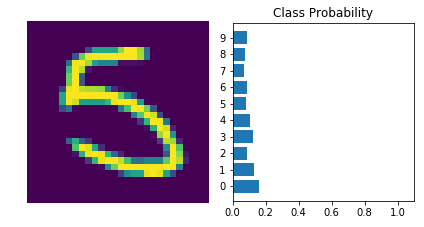

In [3]:
# Test the untrained model

images, labels = next(iter(trainloader))
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [6]:
# Train the model for 10 epochs
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
validloss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    trainloss = 0.0
    validloss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in trainloader:
        data = data.view(-1, 28 * 28)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        trainloss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validloader:
        data = data.view(-1, 28 * 28)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        validloss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    trainloss = trainloss/len(trainloader.dataset)
    validloss = validloss/len(validloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        trainloss,
        validloss
        ))
    
    # save model if validation loss has decreased
    if validloss <= validloss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validloss))
        torch.save(model.state_dict(), 'model.pth')
        validloss_min = validloss

Epoch: 1 	Training Loss: 1.078471 	Validation Loss: 0.118134
Validation loss decreased (inf --> 0.118134).  Saving model ...
Epoch: 2 	Training Loss: 0.453979 	Validation Loss: 0.078435
Validation loss decreased (inf --> 0.078435).  Saving model ...
Epoch: 3 	Training Loss: 0.353694 	Validation Loss: 0.066837
Validation loss decreased (inf --> 0.066837).  Saving model ...
Epoch: 4 	Training Loss: 0.307861 	Validation Loss: 0.059296
Validation loss decreased (inf --> 0.059296).  Saving model ...
Epoch: 5 	Training Loss: 0.278787 	Validation Loss: 0.054254
Validation loss decreased (inf --> 0.054254).  Saving model ...
Epoch: 6 	Training Loss: 0.252654 	Validation Loss: 0.049155
Validation loss decreased (inf --> 0.049155).  Saving model ...
Epoch: 7 	Training Loss: 0.232030 	Validation Loss: 0.045724
Validation loss decreased (inf --> 0.045724).  Saving model ...
Epoch: 8 	Training Loss: 0.213158 	Validation Loss: 0.042406
Validation loss decreased (inf --> 0.042406).  Saving model ...


In [7]:
model.load_state_dict(torch.load('model.pth'))

In [10]:
# initialize lists to monitor test loss and accuracy
testloss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in testloader:
    data = data.view(-1, 28 * 28)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    testloss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
testloss = testloss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(testloss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.074377

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (990/1010)
Test Accuracy of     4: 97% (960/982)
Test Accuracy of     5: 96% (862/892)
Test Accuracy of     6: 97% (937/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 96% (974/1009)

Test Accuracy (Overall): 97% (9771/10000)


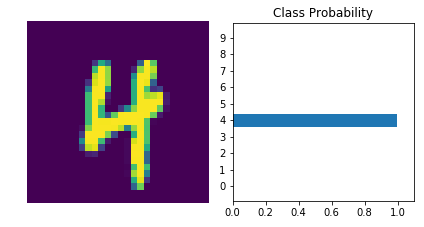

In [11]:
# Test the model after training
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)